## Kernel to load: vax_inc_geo 

In [1]:
import pandas as pd
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from textwrap import wrap
import matplotlib
import matplotlib.patches as mpatches
import math
import re
from collections import Counter
from docx import Document
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt
import pickle
import pycountry
import os
import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)


Cannot find header.dxf (GDAL_DATA is not defined)


In [2]:
notebook_dir = os.path.dirname(os.getcwd())
source_data_path=os.path.join(notebook_dir, "Common Source Data")

In [3]:
with open(os.path.join(source_data_path,'vaccines_sorted_by_use.pickle'),'rb') as handle:
    _,_,_,top_vaccines=pickle.load(handle)
    
top_vaccines=[(i[0],i[1],i[2]) if 'Newca' not in i[1] else (i[0],'Newcastle disease (velogenic)',i[2]) for i in top_vaccines]

In [4]:
SHAPEFILE = os.path.join(source_data_path,'World_Countries_Map/World_Countries__Generalized_.shp')

geo_df = gpd.read_file(SHAPEFILE)
geo_df=geo_df.loc[:,['COUNTRY', 'ISO', 'geometry']]
geo_df.head(3)

,COUNTRY,ISO,geometry
0,Afghanistan,AF,"POLYGON ((61.27655 35.60725, 61.29638 35.62854..."
1,Albania,AL,"POLYGON ((19.57083 41.68527, 19.58195 41.69569..."
2,Algeria,DZ,"POLYGON ((4.60335 36.88791, 4.63555 36.88638, ..."


<AxesSubplot:>

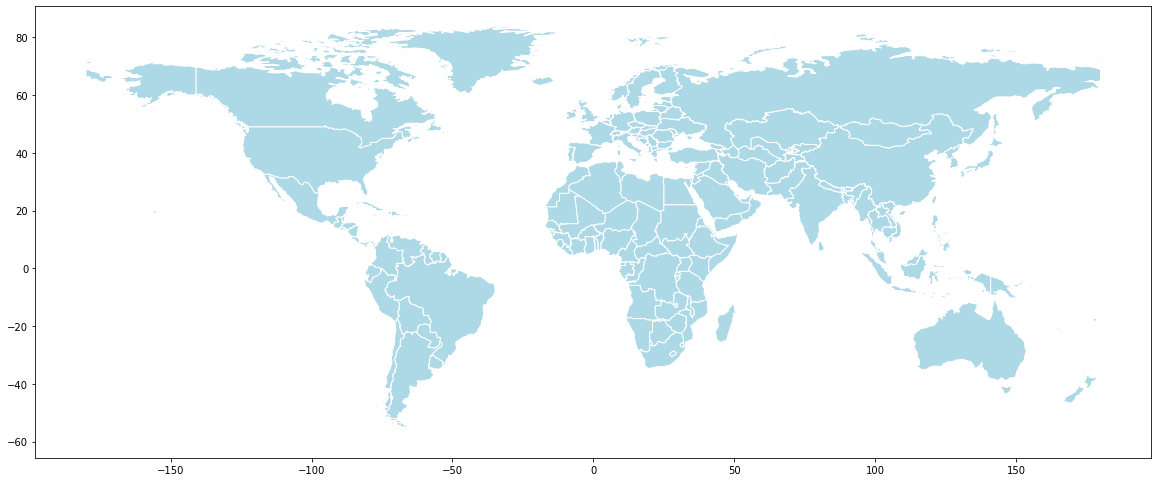

In [5]:
# Drop row for 'Antarctica'. It takes a lot of space in the map and is not of much use
geo_df = geo_df.drop(geo_df.loc[geo_df['COUNTRY'] == 'Antarctica'].index)
geo_df.reset_index(drop=True, inplace=True)

geo_df.plot(figsize=(20, 20), edgecolor='white', linewidth=1, color='lightblue')

In [6]:
def format_as_superscript(number):
    log_output = math.log10(number)

    # Check if log_output is a floating-point number
    if log_output.is_integer():
        superscript_exponent = ''.join(chr(0x2070 + int(digit)) for digit in str(int(log_output)))
    else:
        log_output=round(log_output,2)
        superscript_exponent = ''.join(chr(0x2070 + int(digit)) for digit in str(int(log_output)))

    formatted_text = f"10{superscript_exponent}"
    return formatted_text


In [7]:
pop_countries_geo = geo_df['ISO']

countries = {}
for country in pycountry.countries:
    countries[country.alpha_2] = country.alpha_3


codes_pop_geo = [countries.get(country, 'Unknown code:'+country) for country in pop_countries_geo]

iso3s_pop_geo=[]

for i in pop_countries_geo:
    try:
        iso3s_pop_geo+=[countries[i]]
    except:
        iso3s_pop_geo+=[None]
        
geo_df['ISO3']=iso3s_pop_geo


print(np.unique(codes_pop_geo)) 

['ABW' 'AFG' 'AGO' 'AIA' 'ALB' 'AND' 'ARE' 'ARG' 'ARM' 'ASM' 'ATF' 'ATG'
 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BEN' 'BES' 'BFA' 'BGD' 'BGR' 'BHR' 'BHS'
 'BIH' 'BLM' 'BLR' 'BLZ' 'BMU' 'BOL' 'BRA' 'BRB' 'BRN' 'BTN' 'BVT' 'BWA'
 'CAF' 'CAN' 'CCK' 'CHE' 'CHL' 'CHN' 'CIV' 'CMR' 'COD' 'COG' 'COK' 'COL'
 'COM' 'CPV' 'CRI' 'CUB' 'CUW' 'CXR' 'CYM' 'CYP' 'CZE' 'DEU' 'DJI' 'DMA'
 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FJI' 'FLK'
 'FRA' 'FRO' 'FSM' 'GAB' 'GBR' 'GEO' 'GGY' 'GHA' 'GIB' 'GIN' 'GLP' 'GMB'
 'GNB' 'GNQ' 'GRC' 'GRD' 'GRL' 'GTM' 'GUF' 'GUM' 'GUY' 'HMD' 'HND' 'HRV'
 'HTI' 'HUN' 'IDN' 'IMN' 'IND' 'IOT' 'IRL' 'IRN' 'IRQ' 'ISL' 'ISR' 'ITA'
 'JAM' 'JEY' 'JOR' 'JPN' 'KAZ' 'KEN' 'KGZ' 'KHM' 'KIR' 'KNA' 'KOR' 'KWT'
 'LAO' 'LBN' 'LBR' 'LBY' 'LCA' 'LIE' 'LKA' 'LSO' 'LTU' 'LUX' 'LVA' 'MAF'
 'MAR' 'MCO' 'MDA' 'MDG' 'MDV' 'MEX' 'MHL' 'MKD' 'MLI' 'MLT' 'MMR' 'MNE'
 'MNG' 'MNP' 'MOZ' 'MRT' 'MSR' 'MTQ' 'MUS' 'MWI' 'MYS' 'MYT' 'NAM' 'NCL'
 'NER' 'NFK' 'NGA' 'NIC' 'NIU' 'NLD' 'NOR' 'NPL' 'N

In [8]:
full_incidence=pd.read_csv('Supplementary Spreadsheet- Incidence Estimates.csv')

In [9]:
def powers_between(val_1,val_2):
    
    lower=math.ceil(math.log10(val_1))
    upper=math.floor(math.log10(val_2))
    
    if math.log10(val_1)%1==0:
        lower+=1
        
    if math.log10(val_2)%1==0:
        upper-=1
    
    vals_return=[]
    
    for val in range(lower,upper+1,1):
        vals_return+=[10**val]
    return(vals_return)

In [10]:
def print_scientific_notation(value):
    exponent = int(math.log10(abs(value)))
    mantissa = value / (10 ** exponent)
    
    sign = "⁻" if value < 0 else ""
    superscript_exponent = str(exponent).translate(str.maketrans("0123456789-", "⁰¹²³⁴⁵⁶⁷⁸⁹⁻"))
    
    if mantissa == 1:
        return f"10{sign}{superscript_exponent}"
    else:
        return f"{mantissa:.2f} × 10{sign}{superscript_exponent}"


Poultry Newcastle disease (velogenic)


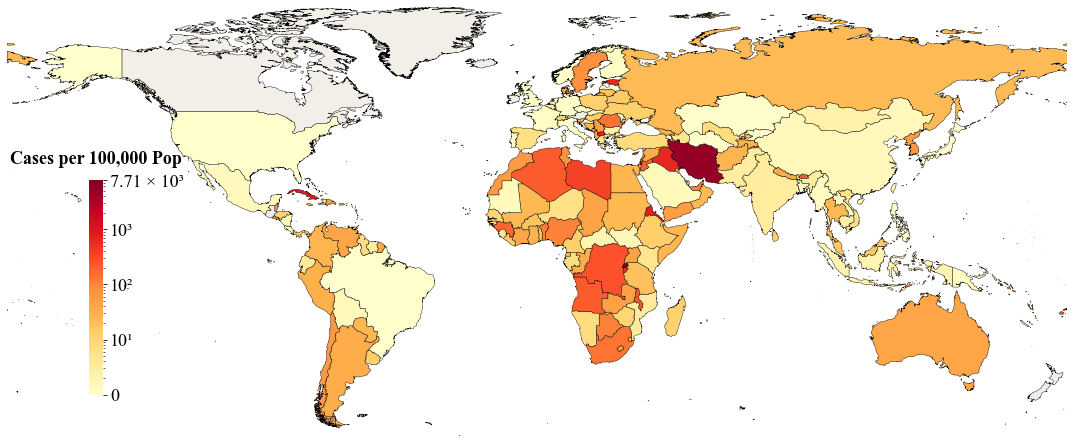

Poultry Infectious bursal disease (Gumboro disease)


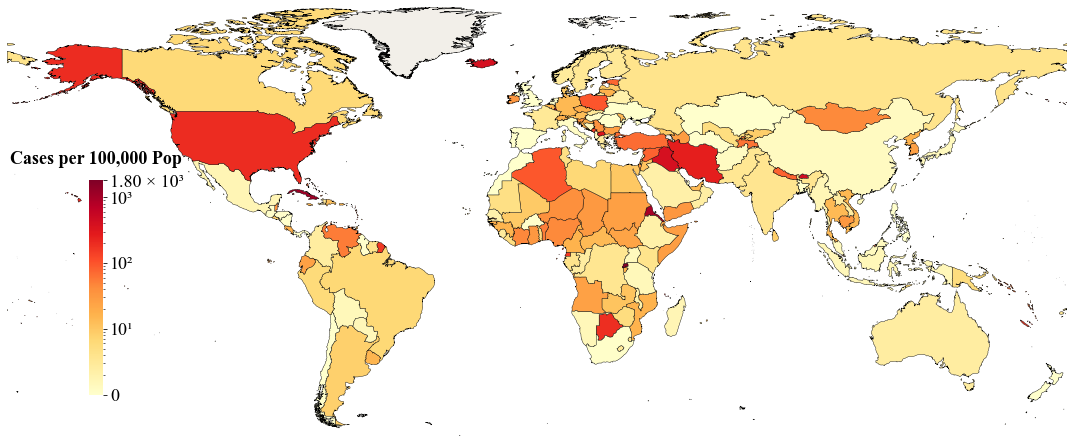

relabeling max
Cattle Anthrax


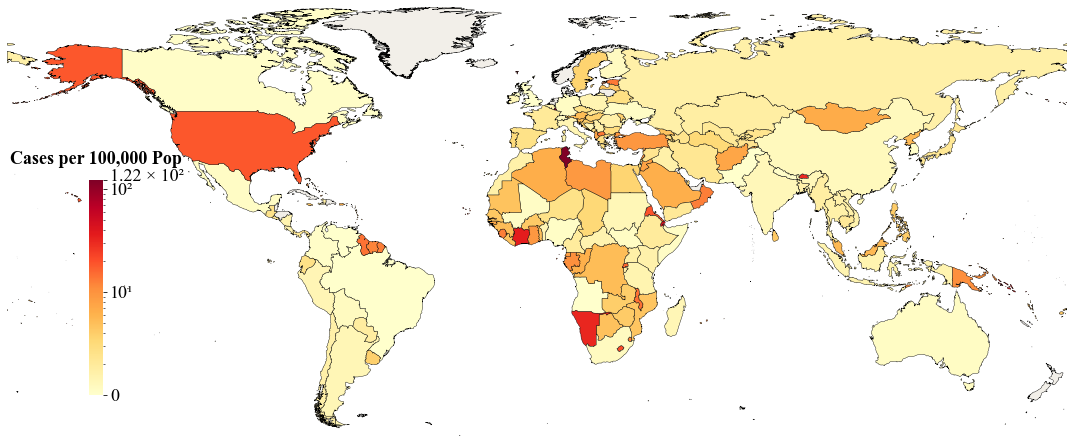

Poultry Avian infectious bronchitis


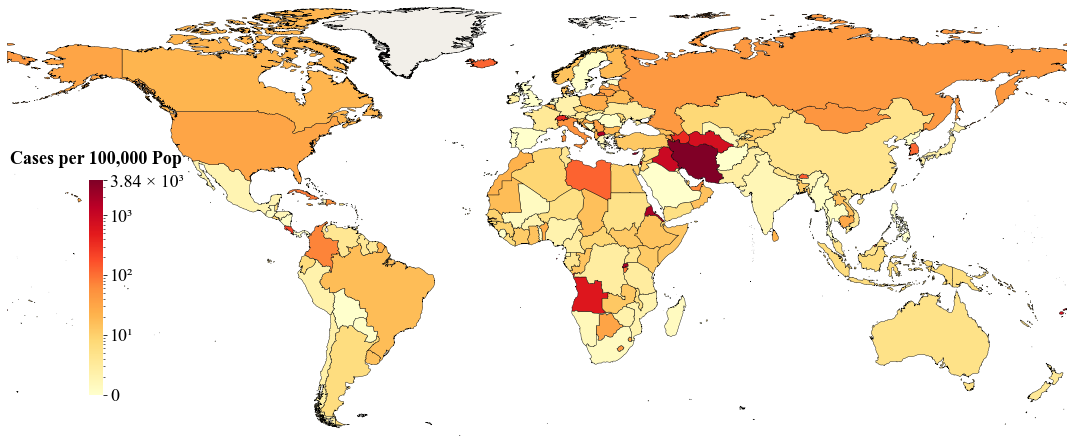

Poultry Marek's disease (-2011)


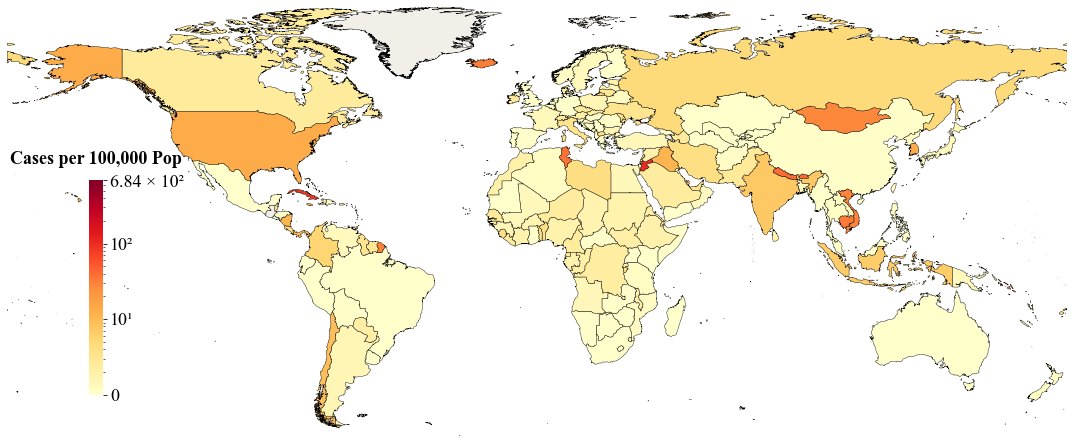

relabeling max
Cattle Rabies virus (Inf. with)


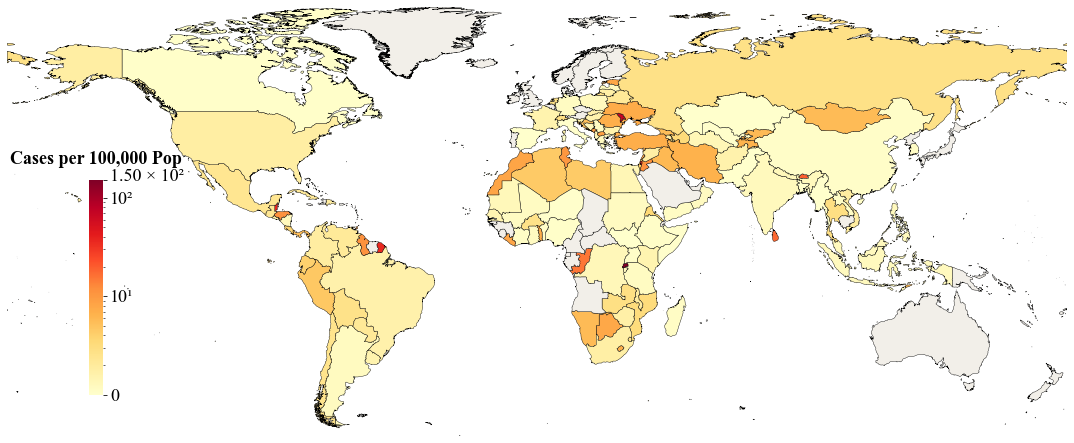

Cattle Foot and mouth disease virus (Inf. with)


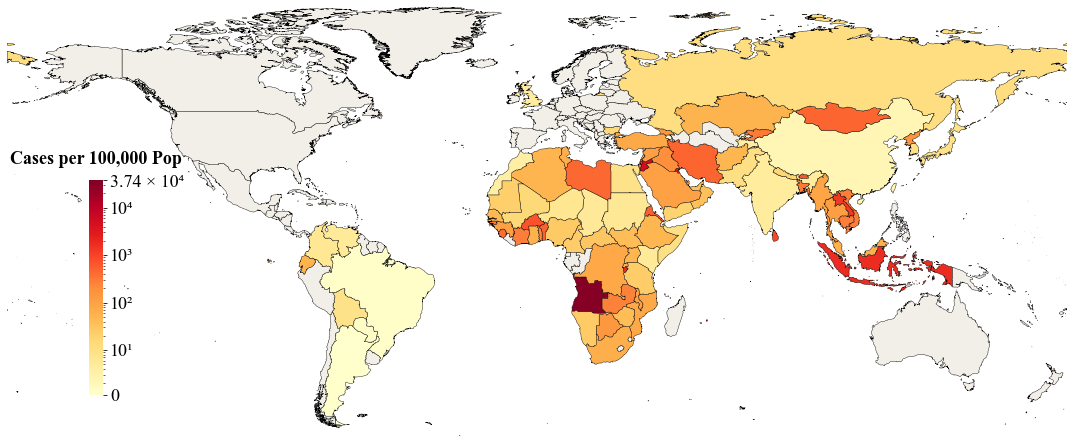

Cattle Brucella abortus (Inf. with)


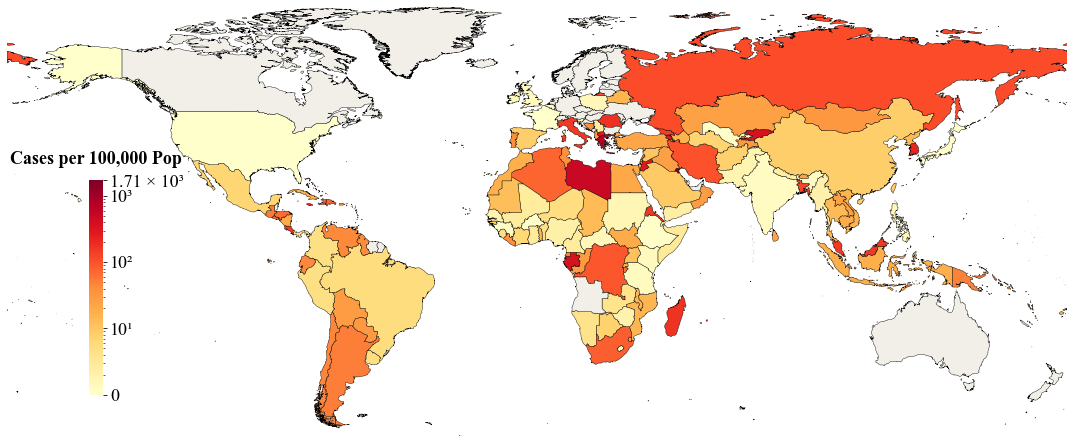

Cattle Lumpy skin disease virus (Inf. with)


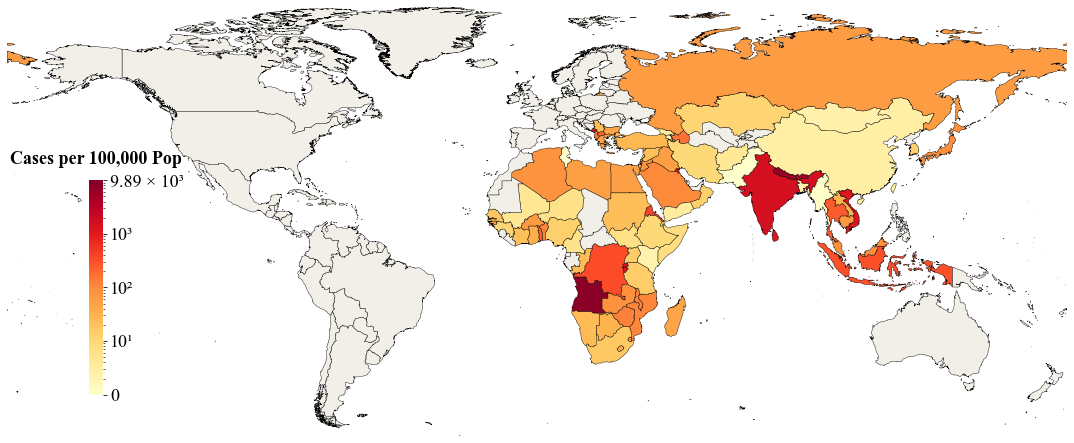

Poultry Avian infectious laryngotracheitis


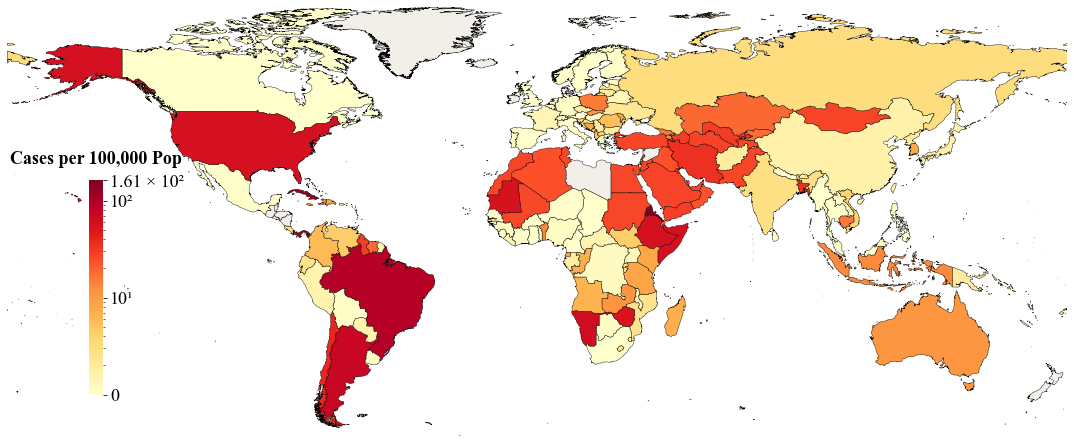

Pigs Classical swine fever virus (Inf. with)


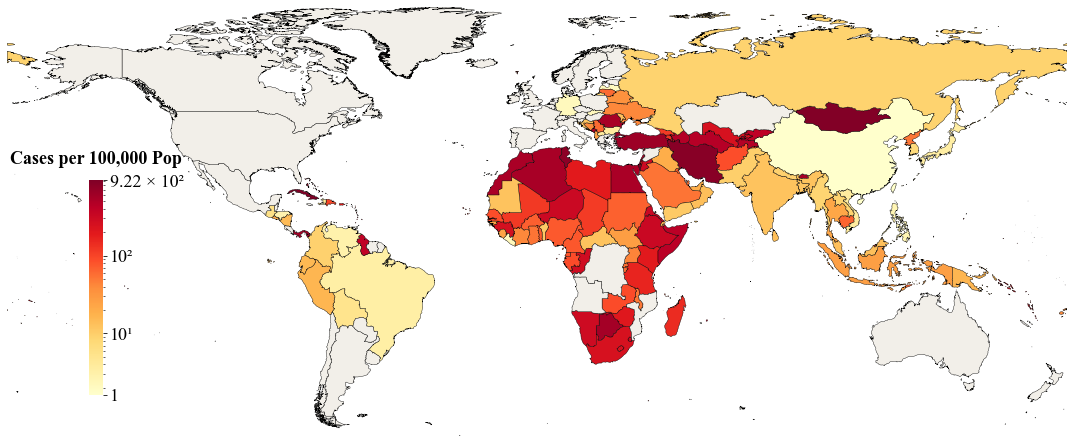

Pigs Anthrax


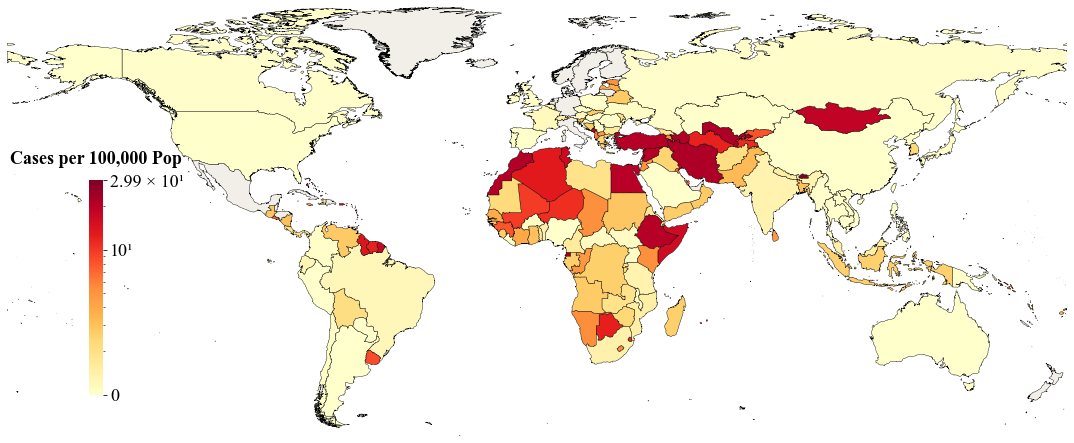

Pigs Rabies virus (Inf. with)


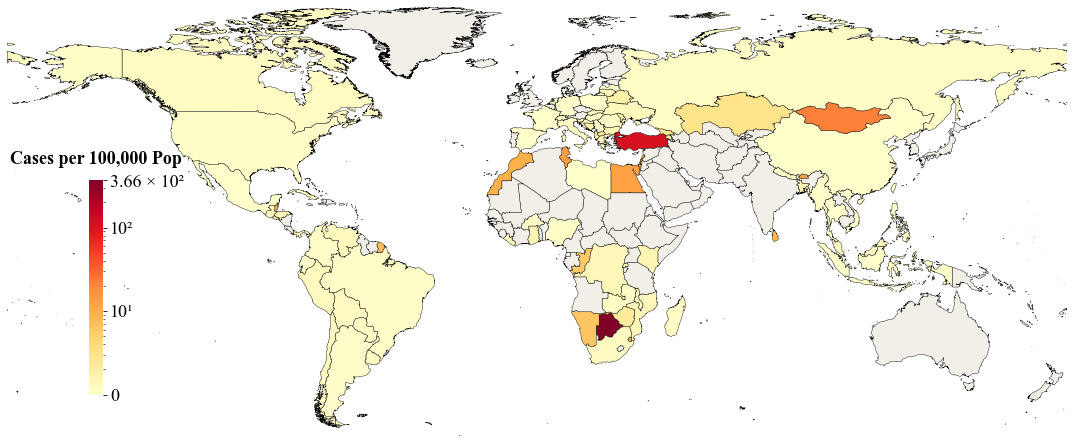

In [11]:
plt.rcParams["font.family"] = "Times New Roman"
countries_missing_data = dict()

animals=[i[0] for i in top_vaccines]
animals=[i if i!='Swine' else 'Pigs' for i in animals ]
vaccines=[i[1] for i in top_vaccines]
for animal, disease in zip((animals[0:10]+animals[14:17]),(vaccines[0:10]+vaccines[14:17])):
    

    plot_df = full_incidence[
        (full_incidence['Animal'] == animal) &
        (full_incidence['Disease'] == disease) &
        (full_incidence['Year'] == 2024)
    ].copy()
    
    plot_df['Incidence (Cases per 100,000)'] += 1
    
    plot_df = plot_df.dropna(subset=['Incidence (Cases per 100,000)'])

    background_color=(170 / 255, 211 / 255, 223 / 255)
    
    merged_df=pd.merge(geo_df,plot_df,how='left',on='ISO3')

    
    col = 'Incidence (Cases per 100,000)'
    cmap = 'YlOrRd'
    
    fig, ax = plt.subplots(1, figsize=(19, 17.5))
    ax.set_facecolor('lightseagreen')
    
    ax.axis('off')
    
    vmin = merged_df[col].min()
    vmax = merged_df[col].max()
    
    finish = merged_df.plot(column=col, norm=LogNorm(vmin=vmin, vmax=vmax), ax=ax, edgecolor='black',
                                linewidth=.4, cmap=cmap, missing_kwds={'color': (242/255,239/255,233/255)})
    


    
    #Adjust the axes limits to tightly fit the map
    ax.set_xlim(merged_df.total_bounds[0], merged_df.total_bounds[2])
    ax.set_ylim(merged_df.total_bounds[1], merged_df.total_bounds[3])
    
    tick_values = [vmin] + powers_between(vmin, vmax) + [vmax]
    tick_labels = [round(vmin - 1)] + [print_scientific_notation(i) for i in powers_between(vmin, vmax)] + [print_scientific_notation(vmax)]
    
    #Create the color bar
    color_bar = fig.colorbar(plt.cm.ScalarMappable(norm=LogNorm(vmin=vmin, vmax=vmax), cmap=cmap), ax=ax,
                             cax=fig.add_axes([0.185, 0.365, 0.01, 0.17]))
    
    color_bar.outline.set_visible(False)
    color_bar.ax.set_title('Cases per 100,000 Pop', y=1.05, weight='bold',fontsize=18)

    color_bar.set_ticks(tick_values)
    color_bar.set_ticklabels(tick_labels)

    # Check if the last two tick values are within 10% of each other
    if len(tick_values) > 1 and abs(tick_values[-1] - tick_values[-2]) / tick_values[-1] <= 0.1:
        print('relabeling max')

        #Get the exact position of the vmax tick in axes coordinates
        tick_positions = color_bar.ax.get_yticks()  
        vmax_position = tick_positions[-1]  

        trans = color_bar.ax.transData.transform
        inv_trans = color_bar.ax.transAxes.inverted().transform
        max_tick_y = inv_trans(trans((0, vmax_position)))[1] 
        max_tick_y+=0.006

        tick_labels = tick_labels[:-1]+['']

        color_bar.set_ticks(tick_values)
        color_bar.set_ticklabels(tick_labels)

        color_bar.ax.text(
            max_tick_x, 
            max_tick_y, 
            '{' + print_scientific_notation(vmax) + '}',
            ha='left',  
            va='center',
            fontsize=18,
            fontname='Times New Roman',  
            transform=color_bar.ax.transAxes,  
            bbox=dict(
                boxstyle="round,pad=0.0", 
                facecolor=(170 / 255, 211 / 255, 223 / 255),  
                alpha=0.6,  
                edgecolor='none',  
            )
            
            
        )
    elif len(tick_values) > 1 and abs(tick_values[-1] - tick_values[-2]) / tick_values[-1] <= 0.35:
        print('relabeling max')

        tick_positions = color_bar.ax.get_yticks()  
        vmax_position = tick_positions[-1] 

        trans = color_bar.ax.transData.transform
        inv_trans = color_bar.ax.transAxes.inverted().transform
        max_tick_y = inv_trans(trans((0, vmax_position)))[1]  
        max_tick_y+=0.015
        max_tick_x=1.5

        tick_labels = tick_labels[:-1]+['']

        color_bar.set_ticks(tick_values)
        color_bar.set_ticklabels(tick_labels)

        color_bar.ax.text(
            max_tick_x, 
            max_tick_y, 
            print_scientific_notation(vmax),  
            ha='left',  
            va='center',
            fontsize=18,
            fontname='Times New Roman',  
            transform=color_bar.ax.transAxes, 
        )
            
    
    fig.axes[1].tick_params(labelsize=18)
    
    os.makedirs("Incidence maps", exist_ok=True)
    
    plt.savefig('Incidence maps/'+animal+'_'+disease + '.svg', format='svg', facecolor=(170 / 255, 211 / 255, 223 / 255),
                bbox_inches='tight', pad_inches=0,dpi=600)
    
    plt.savefig('Incidence maps/'+animal+'_'+disease + '.png', format='png', facecolor=(170 / 255, 211 / 255, 223 / 255),
                bbox_inches='tight', pad_inches=0,dpi=600)

    print(animal,disease)
    plt.show()
    
    

In [12]:
full_vac=pd.read_csv(os.path.join(notebook_dir,'Vaccination Coverage/Supplementary Spreadsheet- Vaccination Coverage Estimates.csv'))

In [13]:
df_animals_incidence=pd.merge(full_incidence,full_vac,how='left',on=['ISO3','Animal','Year','Disease'])

In [14]:
iso3_list =np.unique(full_vac['ISO3'])

#Function to decode ISO3 to country names
def decode_iso3_to_country(iso3_codes):
    decoded_countries = []
    for code in iso3_codes:
        try:
            country = pycountry.countries.get(alpha_3=code)
            if country:
                decoded_countries.append(country.name)
            else:
                decoded_countries.append(f"Unknown code: {code}")
        except Exception as e:
            decoded_countries.append(f"Error for {code}: {e}")
    return decoded_countries

decoded_countries = decode_iso3_to_country(iso3_list)

for iso3, country in zip(iso3_list, decoded_countries):
    print(f"{iso3}: {country}")


ABW: Aruba
AFG: Afghanistan
AGO: Angola
ALB: Albania
AND: Andorra
ARE: United Arab Emirates
ARG: Argentina
ARM: Armenia
ASM: American Samoa
ATG: Antigua and Barbuda
AUS: Australia
AUT: Austria
AZE: Azerbaijan
BDI: Burundi
BEL: Belgium
BEN: Benin
BFA: Burkina Faso
BGD: Bangladesh
BGR: Bulgaria
BHR: Bahrain
BHS: Bahamas
BIH: Bosnia and Herzegovina
BLR: Belarus
BLZ: Belize
BMU: Bermuda
BOL: Bolivia, Plurinational State of
BRA: Brazil
BRB: Barbados
BRN: Brunei Darussalam
BTN: Bhutan
BWA: Botswana
CAF: Central African Republic
CAN: Canada
CHE: Switzerland
CHL: Chile
CHN: China
CIV: Côte d'Ivoire
CMR: Cameroon
COD: Congo, The Democratic Republic of the
COG: Congo
COK: Cook Islands
COL: Colombia
COM: Comoros
CPV: Cabo Verde
CRI: Costa Rica
CUB: Cuba
CUW: Curaçao
CYM: Cayman Islands
CYP: Cyprus
CZE: Czechia
DEU: Germany
DJI: Djibouti
DMA: Dominica
DNK: Denmark
DOM: Dominican Republic
DZA: Algeria
ECU: Ecuador
EGY: Egypt
ERI: Eritrea
ESP: Spain
EST: Estonia
ETH: Ethiopia
FIN: Finland
FJI: Fiji


In [15]:
df_animals_incidence=df_animals_incidence[df_animals_incidence['Year']==2024]

In [16]:
df_animals_incidence.rename(columns={'Year Data_y':'Year Coverage Data',
                                    'Year Data_x':'Year Cases Data'},inplace=True)

In [17]:
# Apply standard rounding for all relevant columns
df_animals_incidence['Aggregate of Latest Reported Cases (up to Year)'] = df_animals_incidence['Aggregate of Latest Reported Cases (up to Year)'] \
    .astype(float).where(df_animals_incidence['Aggregate of Latest Reported Cases (up to Year)'].notna(), np.nan).astype('Int64')
df_animals_incidence['Estimated (Scaled) Cases'] = np.around(df_animals_incidence['Estimated (Scaled) Cases']).astype('Int64')
df_animals_incidence['Incidence (Cases per 100,000)'] = np.around(df_animals_incidence['Incidence (Cases per 100,000)'], decimals=6)
df_animals_incidence['Vaccination Coverage (%)'] = np.around(df_animals_incidence['Vaccination Coverage (%)'], decimals=2)

In [18]:
doc = Document()

poultry_most_countries=[]
cattle_most_countries=[]
pigs_most_countries=[]


for df_plot, plot_title, col_name in zip([df_animals_incidence],
                                         ['Reported Cases of %s in %s'], ['Aggregate of Latest Reported Cases (up to Year)']):
    for animal, disease in zip(animals[0:10] + animals[14:17], vaccines[0:10] + vaccines[14:17]):
        disease_name = disease
        
        # Clean up disease name
        if 'virus' in disease_name:
            disease_name = disease_name.replace(' virus', '')
        if '(Inf. with)' in disease_name:
            disease_name = disease_name.replace(' (Inf. with)', '')
        disease_name = re.sub(" [\(\[]-[\d]{4}[\)\]]", "", disease_name)
        disease_name = disease_name.title()
        
        if disease_name == 'Haemorrhagic Septicaemia (Pasteurella Multocida Serotypes 6:B And 6:E)':
            disease_name = 'Haemorrhagic Septicaemia'
        if disease_name == "Marek'S Disease":
            disease_name = "Marek's Disease"
        
        df_plot2=df_plot[(df_plot['Disease']==disease)&(df_plot['Animal']==animal)].copy()
        
        df_plot2 = df_plot2.reset_index(drop=True)        
        merged_df = pd.merge(right=df_plot2, left=geo_df, how='left', left_on='ISO3', right_on='ISO3')
        merged_df=merged_df[(merged_df['Estimated (Scaled) Cases'].notna())|(merged_df['Aggregate of Latest Reported Cases (up to Year)'].notna())]
        
        #Sort and prepare the top countries by cases 
        df_top = merged_df.sort_values(by=['Aggregate of Latest Reported Cases (up to Year)'], ascending=False).head(10)
        
        df_top=df_top.sort_values(by=['Estimated (Scaled) Cases'], ascending=False)
        
        if animal.lower()=='poultry':
            poultry_most_countries+=df_top['Country_x'].values.tolist()
        elif animal.lower()=='cattle':
            cattle_most_countries+=df_top['Country_x'].values.tolist()
        elif animal.lower()=='pigs':
            pigs_most_countries+=df_top['Country_x'].values.tolist()

        for df, case_type in zip([df_top], ["top reported cases"]):
            df=df.loc[:,['Country_x','Aggregate of Latest Reported Cases (up to Year)','Incidence (Cases per 100,000)','Estimated (Scaled) Cases','Year Cases Data','Vaccination Coverage (%)','Year Coverage Data']]
            df['Incidence (Cases per 100,000)']=df['Incidence (Cases per 100,000)'].round(2)

            df.rename(columns={'Country_x':'Country'},inplace=True)
            if case_type =="top reported cases":
                sentence = f"The top ten countries with the highest aggregate of reported cases by 2024 (one-year representation) of {disease_name} in {animal}."
            else:
                sentence = f"Ten Countries with the lowest aggregate of reported cases by 2024 (one-year representation) of {disease_name} in {animal}."

            paragraph = doc.add_paragraph(sentence)
            paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
            
            table = doc.add_table(rows=1, cols=len(df.columns))
            table.style = 'Table Grid'
            
            hdr_cells = table.rows[0].cells
            for i, column in enumerate(df.columns):
                hdr_cells[i].text = column
                hdr_cells[i].paragraphs[0].runs[0].font.bold = True
            
            for _, row in df.iterrows():
                row_cells = table.add_row().cells
                for i, value in enumerate(row):
                    row_cells[i].text = str(value)
                    row_cells[i].paragraphs[0].runs[0].font.size = Pt(10)
            
            doc.add_paragraph("\n")
        
        doc.add_page_break()

doc.save("Animal_Disease_Tables_top_cases_reported_cases_sorted_by_estimated.docx")

In [19]:
Counter(pigs_most_countries).most_common()

[('Romania', 2),
 ('China', 2),
 ('Russian Federation', 2),
 ('Ukraine', 2),
 ('Moldova, Republic of', 2),
 ('Cuba', 1),
 ('South Africa', 1),
 ('Serbia', 1),
 ('Thailand', 1),
 ('Madagascar', 1),
 ('Indonesia', 1),
 ('Cambodia', 1),
 ('India', 1),
 ('Kenya', 1),
 ('Ghana', 1),
 ('Uruguay', 1),
 ('El Salvador', 1),
 ('Nepal', 1),
 ('Lesotho', 1),
 ('Brazil', 1),
 ('Belarus', 1),
 ('Botswana', 1),
 ('Peru', 1),
 ('Venezuela, Bolivarian Republic of', 1),
 ('Georgia', 1)]

In [20]:
Counter(cattle_most_countries).most_common()

[('Türkiye, Republic of', 3),
 ('India', 3),
 ('Russian Federation', 3),
 ('Iran, Islamic Republic of', 3),
 ('Ethiopia', 2),
 ('Rwanda', 2),
 ('Brazil', 2),
 ('Indonesia', 2),
 ('Viet Nam', 2),
 ('Chad', 1),
 ('Namibia', 1),
 ("Côte d'Ivoire", 1),
 ('Eritrea', 1),
 ('Uruguay', 1),
 ('Afghanistan', 1),
 ('Angola', 1),
 ('Mexico', 1),
 ('Honduras', 1),
 ('Morocco', 1),
 ('Ukraine', 1),
 ('Burkina Faso', 1),
 ('Gambia', 1),
 ("Lao People's Democratic Republic", 1),
 ('Mongolia', 1),
 ('Burundi', 1),
 ('Argentina', 1),
 ('Italy', 1),
 ('South Africa', 1),
 ('Korea, Republic of', 1),
 ('Kyrgyzstan', 1),
 ('China', 1),
 ('Venezuela, Bolivarian Republic of', 1),
 ('Nepal', 1),
 ('Sri Lanka', 1),
 ('Bhutan', 1),
 ('Thailand', 1),
 ('Zimbabwe', 1)]

In [21]:
Counter(poultry_most_countries).most_common()

[('Iraq', 5),
 ('Korea, Republic of', 5),
 ('Iran, Islamic Republic of', 4),
 ('Russian Federation', 4),
 ('Rwanda', 3),
 ('Brazil', 3),
 ('Colombia', 3),
 ('China', 3),
 ('Nigeria', 2),
 ('Poland', 2),
 ('Cuba', 2),
 ('Chile', 2),
 ('South Africa', 1),
 ('Algeria', 1),
 ('Romania', 1),
 ('Peru', 1),
 ('Thailand', 1),
 ('Viet Nam', 1),
 ('Costa Rica', 1),
 ('Jordan', 1),
 ('Nepal', 1),
 ('Trinidad and Tobago', 1),
 ('Argentina', 1),
 ('Namibia', 1)]